# Projeto do Aluno

## Imports

In [212]:
import pandas as pd
import numpy as np
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## Data Load

In [213]:
df=pd.read_csv(r'C:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\dataset\hotel.csv.csv')

## 1.0 Descrição dos Dados

In [214]:
df1=df.copy()

In [215]:
# Garantir que os nomes das colunas estão limpos
df1.columns = df1.columns.str.strip().str.lower()

### 1.1 Dimensão dos Dados

In [216]:

df1.shape

(36275, 19)

### 1.2 Tipos dos Dados

In [217]:
df1.dtypes

booking_id                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

In [218]:
df1.head(1).T

,0
booking_id,INN00001
no_of_adults,2
no_of_children,0
no_of_weekend_nights,1
no_of_week_nights,2
type_of_meal_plan,Meal Plan 1
required_car_parking_space,0
room_type_reserved,Room_Type 1
lead_time,224
arrival_year,2017


### 1.3 Check Na

In [219]:
df1.isna().sum()

booking_id                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

### 1.4 Estatística Descritiva

In [220]:
num_atributos = df1.select_dtypes(include=['int64', 'float64'])
cat_atributos = df1.select_dtypes(include=['object'])

In [221]:
num_atributos.head(1)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,2,0,1,2,0,224,2017,10,2,0,0,0,65.0,0


In [222]:
cat_atributos.head(1)

,booking_id,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
0,INN00001,Meal Plan 1,Room_Type 1,Offline,Not_Canceled


In [223]:
# Frequência absoluta das classes da variável alvo
df1['booking_status'].value_counts()


booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64

In [224]:
# Frequência relativa da variável alvo
df1['booking_status'].value_counts(normalize=True) * 100


booking_status
Not_Canceled    67.236389
Canceled        32.763611
Name: proportion, dtype: float64

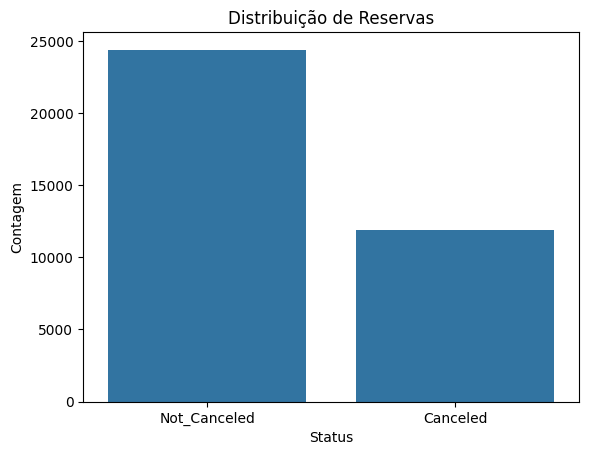

In [225]:
sns.countplot(x='booking_status', data=df1)
plt.title('Distribuição de Reservas')
plt.xlabel('Status')
plt.ylabel('Contagem')
plt.show()


### 1.5 Análise exploratória numérica

In [226]:
# Medidadas de Tendência Central
ct1=pd.DataFrame(num_atributos.apply(np.mean)).T
ct2=pd.DataFrame(num_atributos.apply(np.median)).T

# Medidas de Dispersão
disp1=pd.DataFrame(num_atributos.apply(np.std)).T
disp2=pd.DataFrame(num_atributos.apply(np.min)).T
disp3=pd.DataFrame(num_atributos.apply(np.max)).T
disp4=pd.DataFrame(num_atributos.apply(lambda x: x.max() - x.min())).T
disp5=pd.DataFrame(num_atributos.apply(lambda x: x.skew())).T
disp6=pd.DataFrame(num_atributos.apply(lambda x: x.kurtosis())).T

# Percentis
perc1=pd.DataFrame(num_atributos.apply(lambda x: np.percentile(x, 25))).T
perc2=pd.DataFrame(num_atributos.apply(lambda x: np.percentile(x, 50))).T
perc3=pd.DataFrame(num_atributos.apply(lambda x: np.percentile(x, 75))).T
perc4=pd.DataFrame(num_atributos.apply(lambda x: np.percentile(x, 85))).T
perc5=pd.DataFrame(num_atributos.apply(lambda x: np.percentile(x, 90))).T

m=pd.concat([disp2, disp3, disp4, ct1, ct2, disp1,  disp5, disp6, perc1, perc2, perc3, perc4, perc5]).T.reset_index()

m.columns=['Atributos', 'Mínimo', 'Máximo', 'Range', 'Média', 'Mediana', 'Desvio Padrão',   'Assimetria', 'Curtose',
           'Percentil 25', 'Percentil 50', 'Percentil 75',  'Percentil 85', 'Percentil 90']

m

,Atributos,Mínimo,Máximo,Range,Média,Mediana,Desvio Padrão,Assimetria,Curtose,Percentil 25,Percentil 50,Percentil 75,Percentil 85,Percentil 90
0,no_of_adults,0.0,4.0,4.0,1.844962,2.00,0.518708,-0.333295,0.814822,2.0,2.00,2.0,2.0,2.000
1,no_of_children,0.0,10.0,10.0,0.105279,0.00,0.402643,4.710350,36.981856,0.0,0.00,0.0,0.0,0.000
2,no_of_weekend_nights,0.0,7.0,7.0,0.810724,1.00,0.870632,0.737616,0.298858,0.0,1.00,2.0,2.0,2.000
3,no_of_week_nights,0.0,17.0,17.0,2.204300,2.00,1.410885,1.599350,7.798284,1.0,2.00,3.0,3.0,4.000
4,required_car_parking_space,0.0,1.0,1.0,0.030986,0.00,0.173278,5.413643,27.309037,0.0,0.00,0.0,0.0,0.000
5,lead_time,0.0,443.0,443.0,85.232557,57.00,85.929632,1.292492,1.179594,17.0,57.00,126.0,179.0,213.000
6,arrival_year,2017.0,2018.0,1.0,2017.820427,2018.00,0.383831,-1.669695,0.787926,2018.0,2018.00,2018.0,2018.0,2018.000
7,arrival_month,1.0,12.0,11.0,7.423653,8.00,3.069852,-0.348229,-0.933189,5.0,8.00,10.0,11.0,11.000
8,arrival_date,1.0,31.0,30.0,15.596995,16.00,8.740327,0.028809,-1.157214,8.0,16.00,23.0,26.0,28.000
9,repeated_guest,0.0,1.0,1.0,0.025637,0.00,0.158051,6.002888,34.036545,0.0,0.00,0.0,0.0,0.000


### 1.6 Análise exploratória categórica

In [227]:
cat_atributos.describe().T

,count,unique,top,freq
booking_id,36275,36275,INN36275,1
type_of_meal_plan,36275,4,Meal Plan 1,27835
room_type_reserved,36275,7,Room_Type 1,28130
market_segment_type,36275,5,Online,23214
booking_status,36275,2,Not_Canceled,24390


## 2.0 Feature Engineering

In [228]:
df2=df1.copy()

In [229]:
# Lista de colunas categóricas
cat_cols = df2.select_dtypes(include='object').columns

# Instanciando o LabelEncoder
le = LabelEncoder()

# Aplicando o LabelEncoder em todas as colunas categóricas, exceto a variável alvo
for col in cat_cols:
    if col != 'booking_status':
        df2[col] = le.fit_transform(df2[col])

# Conversão da variável alvo Transformar a coluna booking_status em variável binária:
df2['booking_status'] = df2['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

#Criação de Novas Features
# Total de noites
df2['total_nights'] = df2['no_of_weekend_nights'] + df2['no_of_week_nights']

# Pessoas por reserva
df2['total_people'] = df2['no_of_adults'] + df2['no_of_children']

df2.head(1)

,booking_id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,total_nights,total_people
0,0,2,0,1,2,0,0,0,224,2017,...,2,3,0,0,0,65.0,0,0,3,2


In [230]:
df2.isna().sum()

booking_id                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
total_nights                            0
total_people                            0
dtype: int64

## 3.0 Análise Exploratória de Dados

In [231]:
df3=df2.copy()

### 3.1 Análise Univariada 

#### 3.1.1 Variável Resposta

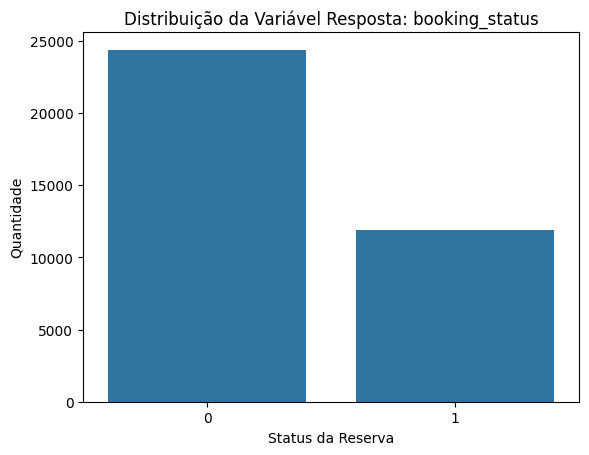

booking_status
0    67.236389
1    32.763611
Name: proportion, dtype: float64

In [232]:
# Distribuição da variável resposta
sns.countplot(x='booking_status', data=df3)
plt.title('Distribuição da Variável Resposta: booking_status')
plt.xlabel('Status da Reserva')
plt.ylabel('Quantidade')
plt.show()

# Porcentagens
df3['booking_status'].value_counts(normalize=True) * 100


#### 3.1.2 Variáveis Numéricas

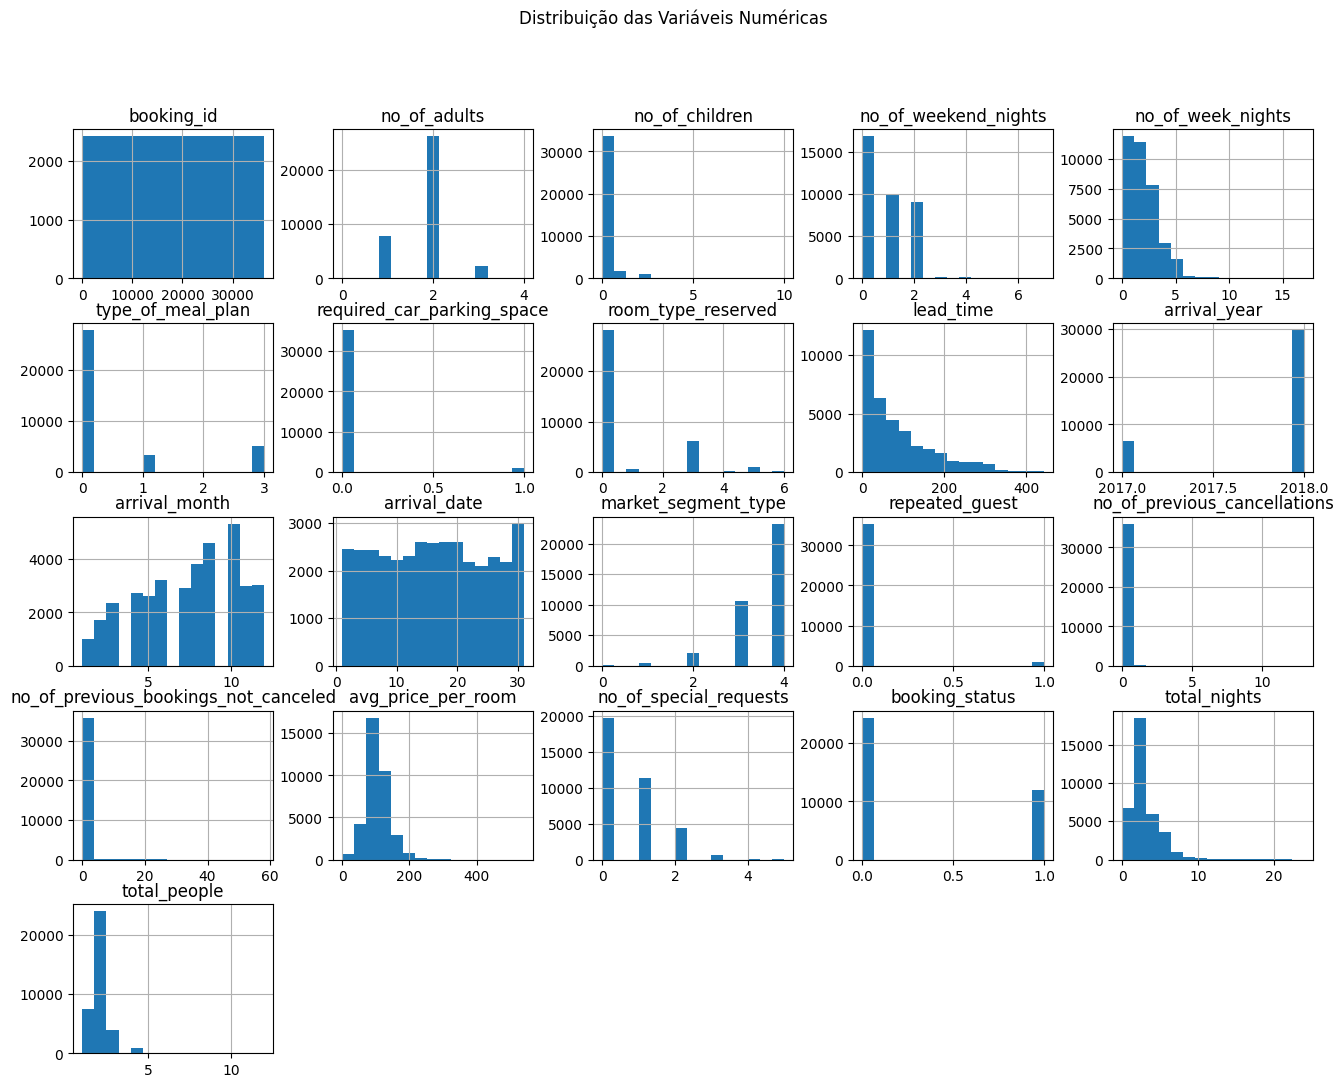

In [233]:
# Selecionar variáveis numéricas
num_cols = df3.select_dtypes(include=['int64', 'float64']).columns

# Histograma para cada variável numérica
df3[num_cols].hist(bins=15, figsize=(16, 12))
plt.suptitle('Distribuição das Variáveis Numéricas')
plt.show()

#### 3.1.3 Variáveis Categóricas

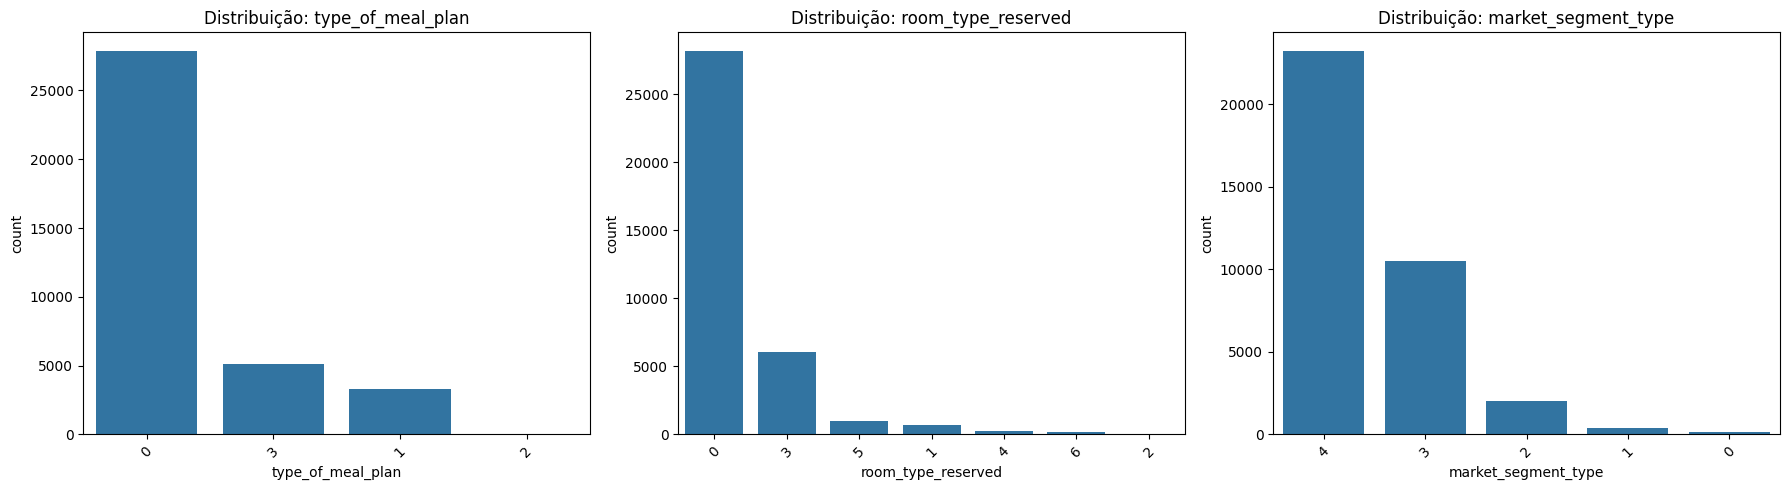

In [234]:
# Lista das colunas categóricas codificadas
cat_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']

# Criar uma figura com 3 subplots lado a lado
plt.figure(figsize=(18, 5))

# Loop para cada subplot
for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=col, data=df3, order=df3[col].value_counts().index)
    plt.title(f'Distribuição: {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 3.2 Análise Bivariada 

#### 3.2.1 Variáveis Numéricas x booking_status

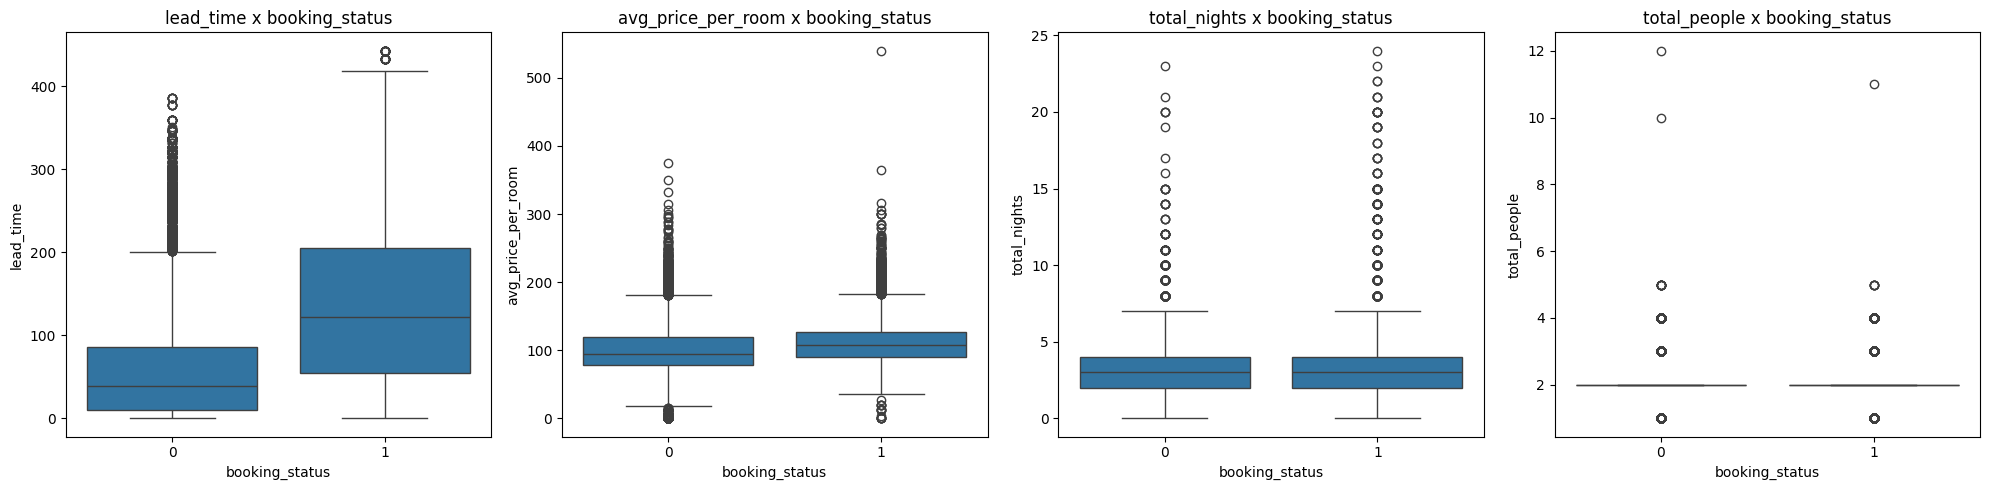

In [235]:
# Lista de variáveis numéricas relevantes
num_cols = ['lead_time', 'avg_price_per_room', 'total_nights', 'total_people']

# Criar boxplots lado a lado
plt.figure(figsize=(20, 5))

for i, col in enumerate(num_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(x='booking_status', y=col, data=df3)
    plt.title(f'{col} x booking_status')
    plt.xlabel('booking_status')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

#### 3.2.2 Variáveis Categóricas x booking_status

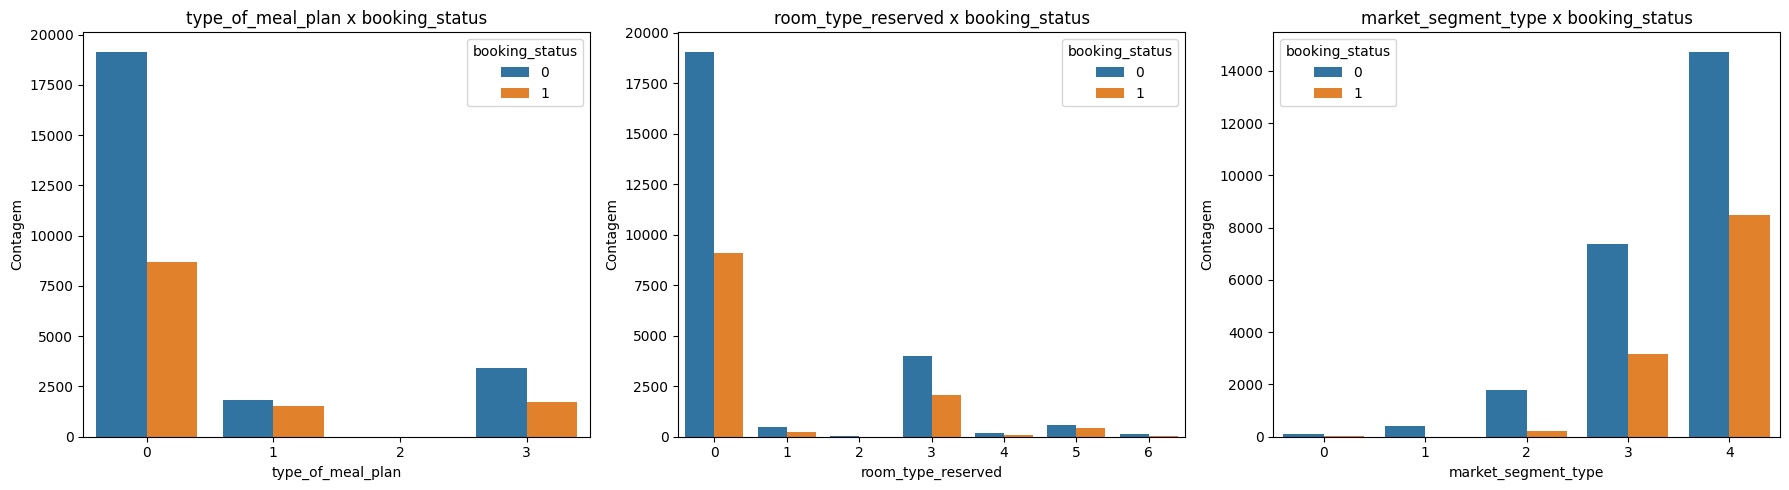

In [236]:
# Variáveis categóricas (codificadas previamente)
cat_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']

# Criar gráfico para cada variável categórica
plt.figure(figsize=(18, 5))

for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=col, hue='booking_status', data=df3)
    plt.title(f'{col} x booking_status')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.legend(title='booking_status')

plt.tight_layout()
plt.show()

### 3.3 Análise Multivariada

#### 3.3.1 Atributos Numéricos

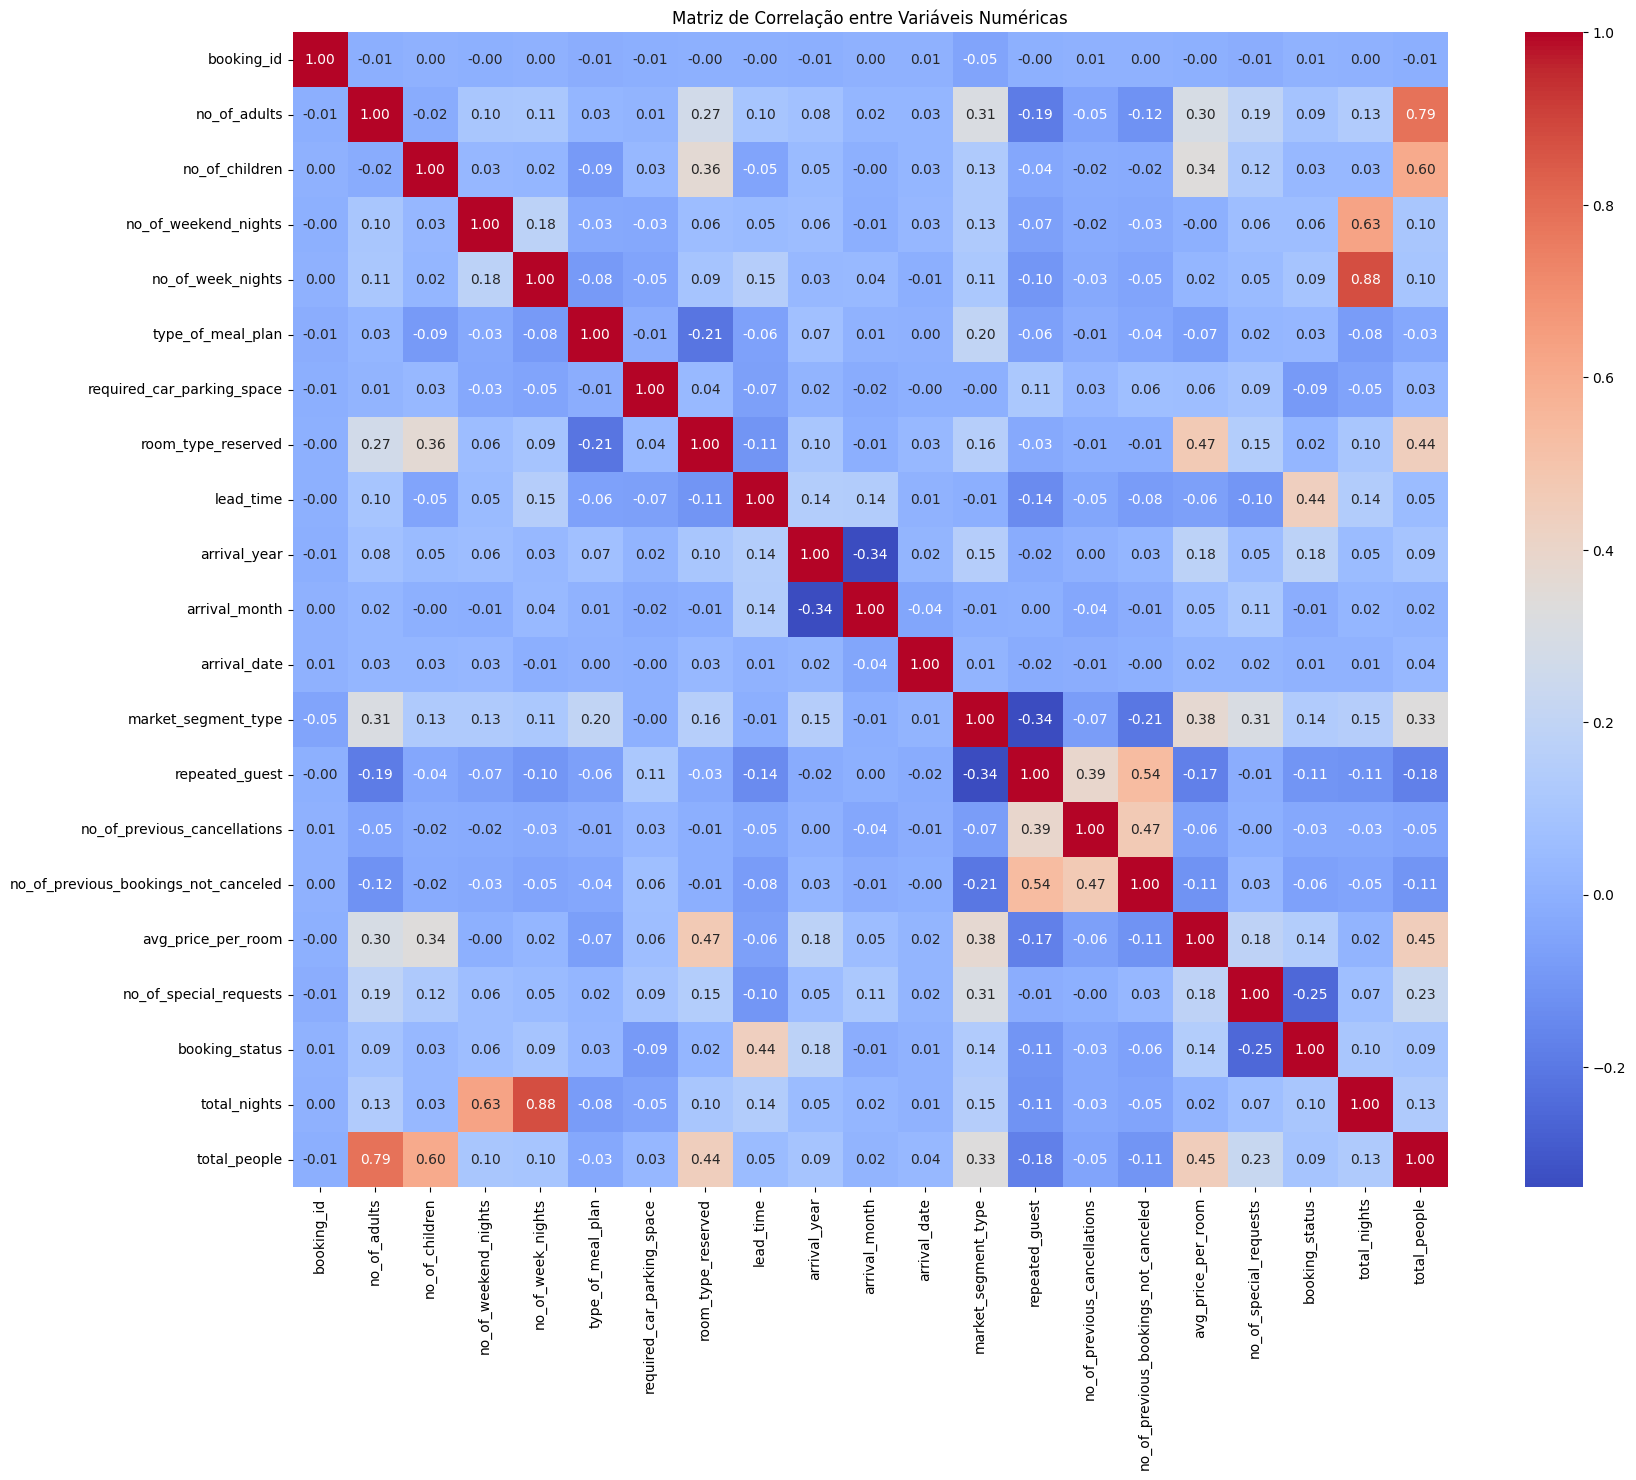

In [237]:
# Selecionar variáveis numéricas
num_cols_corr = df3.select_dtypes(include=['int64', 'float64']).columns

# Calcular matriz de correlação
corr = df3[num_cols_corr].corr()

# Plotar o heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar=True)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

#### 3.3.1 Atributos Categóricos

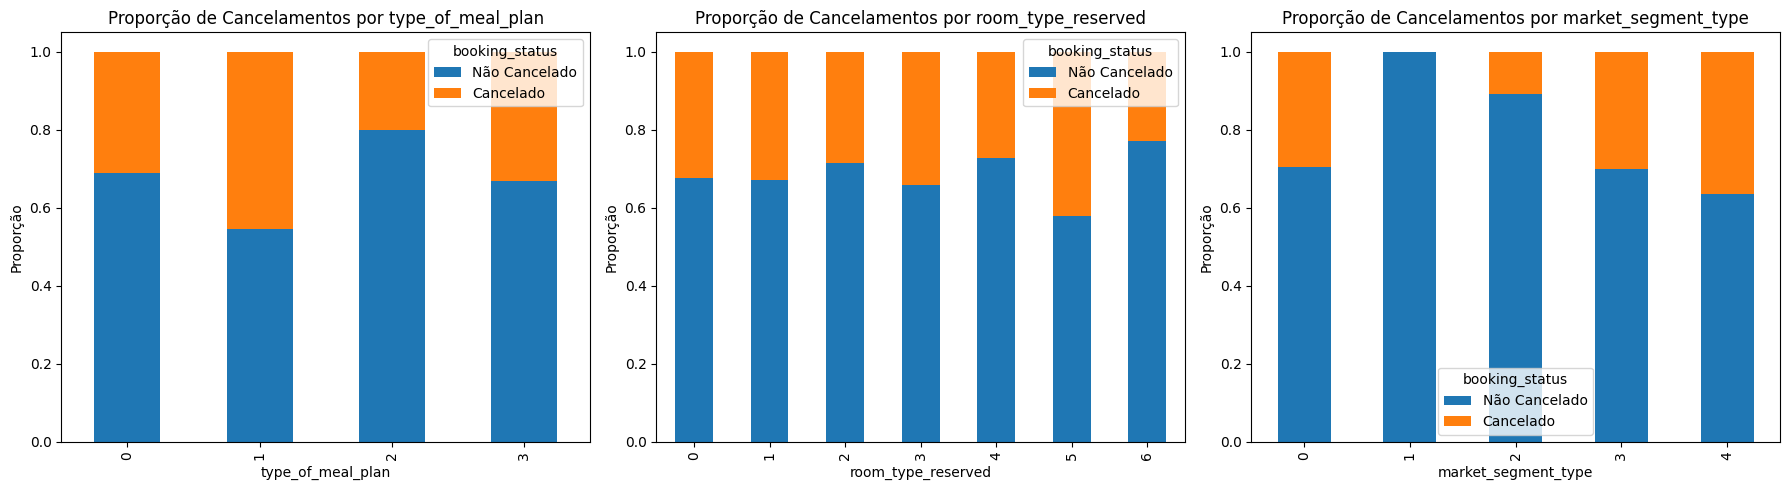

In [238]:
# Lista de atributos categóricos
cat_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']

# Plotando proporções por categoria e booking_status
plt.figure(figsize=(18, 5))

for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i + 1)
    prop_df = df3.groupby([col, 'booking_status']).size().unstack().apply(lambda x: x / x.sum(), axis=1)
    prop_df.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Proporção de Cancelamentos por {col}')
    plt.xlabel(col)
    plt.ylabel('Proporção')
    plt.legend(title='booking_status', labels=['Não Cancelado', 'Cancelado'])

plt.tight_layout()
plt.show()

## 4.0 Modelagem de Dados

In [239]:
df4 = df3.copy()

### 4.1 Features selecionadas

In [240]:
selected_features = [
    'no_of_adults',
    'no_of_children',
    'no_of_weekend_nights',
    'no_of_week_nights',
    'type_of_meal_plan',
    'required_car_parking_space',
    'room_type_reserved',
    'lead_time',
    'arrival_month',
    'market_segment_type',
    'repeated_guest',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    'avg_price_per_room',
    'no_of_special_requests',
    'total_nights',
    'total_people'
]

# Variável alvo
target = 'booking_status'

### 4.2 Dados de entrada (X) e saída (y)

In [241]:
X = df4[selected_features]
y = df4[target]

### 4.3 Divisão em treino e teste

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 4.4 Escalonamento 

In [243]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.5 Seleção de Features com Boruta

In [244]:
rf = RandomForestClassifier(n_estimators='auto', random_state=42, n_jobs=-1, class_weight='balanced')
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
boruta_selector.fit(X_train_scaled, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	12
I

,estimator,RandomForestC...0x28AC21ADB40)
,n_estimators,'auto'
,perc,100
,alpha,0.05
,two_step,True
,max_iter,100
,random_state,RandomState(M... 0x28AC21ADB40
,verbose,2
,early_stopping,False
,n_iter_no_change,20
,n_estimators,31


### 4.6 Features selecionadas

In [245]:
X_train_selected = X_train_scaled[:, boruta_selector.support_]
X_test_selected = X_test_scaled[:, boruta_selector.support_]

In [246]:
# selected_features_boruta já está criado
print("Features selecionadas pelo Boruta:", selected_features_boruta)

Features selecionadas pelo Boruta: ['lead_time', 'arrival_month', 'avg_price_per_room', 'no_of_special_requests']


### 4.7 Salvando os Arquivos

In [247]:
# Caminho para salvar os arquivos
save_path = 'models/'
os.makedirs(save_path, exist_ok=True)

# Salvar o scaler
scaler_path = os.path.join(save_path, 'scaler.pkl')
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

# Salvar o Boruta selector
boruta_path = os.path.join(save_path, 'boruta_selector.pkl')
with open(boruta_path, 'wb') as file:
    pickle.dump(boruta_selector, file)

# Salvar os dados de treino e teste
X_train_selected_path = os.path.join(save_path, 'X_train_selected.pkl')
X_test_selected_path = os.path.join(save_path, 'X_test_selected.pkl')
y_train_path = os.path.join(save_path, 'y_train.pkl')
y_test_path = os.path.join(save_path, 'y_test.pkl')

with open(X_train_selected_path, 'wb') as file:
    pickle.dump(X_train_selected, file)

with open(X_test_selected_path, 'wb') as file:
    pickle.dump(X_test_selected, file)

with open(y_train_path, 'wb') as file:
    pickle.dump(y_train, file)

with open(y_test_path, 'wb') as file:
    pickle.dump(y_test, file)

## 5.0 Machine Learning Models

In [248]:
df5=df4.copy()

### 5.1 Randon Forest

In [249]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_selected, y_train)
rf_pred = rf_model.predict(X_test_selected)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4878
           1       0.83      0.78      0.80      2377

    accuracy                           0.87      7255
   macro avg       0.86      0.85      0.86      7255
weighted avg       0.87      0.87      0.87      7255



### 5.2 Decision Tree

In [250]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_selected, y_train)
dt_pred = dt_model.predict(X_test_selected)
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4878
           1       0.77      0.77      0.77      2377

    accuracy                           0.85      7255
   macro avg       0.83      0.83      0.83      7255
weighted avg       0.85      0.85      0.85      7255



### 5.3 LighGBM Classifier

In [251]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_selected, y_train)
lgbm_pred = lgbm_model.predict(X_test_selected)
print(classification_report(y_test, lgbm_pred))

[LightGBM] [Info] Number of positive: 9508, number of negative: 19512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327636 -> initscore=-0.718896
[LightGBM] [Info] Start training from score -0.718896
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4878
           1       0.85      0.69      0.76      2377

    accuracy                           0.86      7255
   macro avg       0.86      0.82      0.83      7255
weighted avg       0.86      0.86      0.86      7255



c:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\pa6\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### 5.4 XGBosst

In [252]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_selected, y_train)
xgb_pred = xgb_model.predict(X_test_selected)
print(classification_report(y_test, xgb_pred))

c:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\pa6\lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4878
           1       0.84      0.73      0.78      2377

    accuracy                           0.87      7255
   macro avg       0.86      0.83      0.84      7255
weighted avg       0.86      0.87      0.86      7255



### 5.5 Comparação dos Modelos

In [254]:
models = {
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'LightGBM': lgbm_model,
    'XGBoost': xgb_model
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_selected)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

pd.DataFrame(results).T

c:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\pa6\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,Precision,Recall,F1-Score
Random Forest,0.874707,0.830929,0.775347,0.802176
Decision Tree,0.849897,0.773810,0.765671,0.769719
LightGBM,0.860372,0.854102,0.692049,0.764583
XGBoost,0.866161,0.840271,0.730332,0.781454


## 6.0 Fine Tunning

### 6.1 Random Forest – Fine Tuning

In [255]:
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_selected, y_train)

# Melhores parâmetros
print("Melhores Parâmetros:", grid_rf.best_params_)
print("Melhor F1-Score:", grid_rf.best_score_)

Melhores Parâmetros: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Melhor F1-Score: 0.7661997393763961


### 6.2 XGBoost – Fine Tuning

In [256]:
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train_selected, y_train)

# Melhores parâmetros
print("Melhores Parâmetros:", grid_xgb.best_params_)
print("Melhor F1-Score:", grid_xgb.best_score_)

c:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\pa6\lib\site-packages\xgboost\training.py:183: UserWarning: [21:43:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores Parâmetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'subsample': 1.0}
Melhor F1-Score: 0.7898995668845485


### 6.3 LightGBM – Fine Tuning

In [257]:
param_grid_lgbm = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0]
}

grid_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1)
grid_lgbm.fit(X_train_selected, y_train)

# Melhores parâmetros
print("Melhores Parâmetros:", grid_lgbm.best_params_)
print("Melhor F1-Score:", grid_lgbm.best_score_)

[LightGBM] [Info] Number of positive: 9508, number of negative: 19512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327636 -> initscore=-0.718896
[LightGBM] [Info] Start training from score -0.718896
Melhores Parâmetros: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.7}
Melhor F1-Score: 0.7880593613814074


## 7.0 Final Model

### 7.1 Treinando Modelos com os Melhores Hiperparâmetros

In [258]:
best_rf = RandomForestClassifier(
    n_estimators=grid_rf.best_params_['n_estimators'],
    max_depth=grid_rf.best_params_['max_depth'],
    min_samples_split=grid_rf.best_params_['min_samples_split'],
    class_weight=grid_rf.best_params_['class_weight'],
    random_state=42
)
best_rf.fit(X_train_selected, y_train)

best_xgb = XGBClassifier(
    n_estimators=grid_xgb.best_params_['n_estimators'],
    max_depth=grid_xgb.best_params_['max_depth'],
    learning_rate=grid_xgb.best_params_['learning_rate'],
    subsample=grid_xgb.best_params_['subsample'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_xgb.fit(X_train_selected, y_train)

best_lgbm = LGBMClassifier(
    n_estimators=grid_lgbm.best_params_['n_estimators'],
    max_depth=grid_lgbm.best_params_['max_depth'],
    learning_rate=grid_lgbm.best_params_['learning_rate'],
    subsample=grid_lgbm.best_params_['subsample'],
    random_state=42
)
best_lgbm.fit(X_train_selected, y_train)

c:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\pa6\lib\site-packages\xgboost\training.py:183: UserWarning: [21:45:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 9508, number of negative: 19512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327636 -> initscore=-0.718896
[LightGBM] [Info] Start training from score -0.718896


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.3
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### 7.2 Avaliação dos Modelos

In [259]:
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

results_final = []
results_final.append(evaluate_model('Random Forest', best_rf, X_test_selected, y_test))
results_final.append(evaluate_model('XGBoost', best_xgb, X_test_selected, y_test))
results_final.append(evaluate_model('LightGBM', best_lgbm, X_test_selected, y_test))

pd.DataFrame(results_final).T

c:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\pa6\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,0,1,2
Modelo,Random Forest,XGBoost,LightGBM
Accuracy,0.844521,0.87195,0.872226
Precision,0.742902,0.835807,0.835028
Recall,0.803534,0.758098,0.760202
F1-Score,0.772029,0.795058,0.79586


### 7.3 Matriz de Confusão Comparativa

c:\Users\jadso\Documentos\pos_graduacao\6_Projeto_Integrador_I\pa6\pa6\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


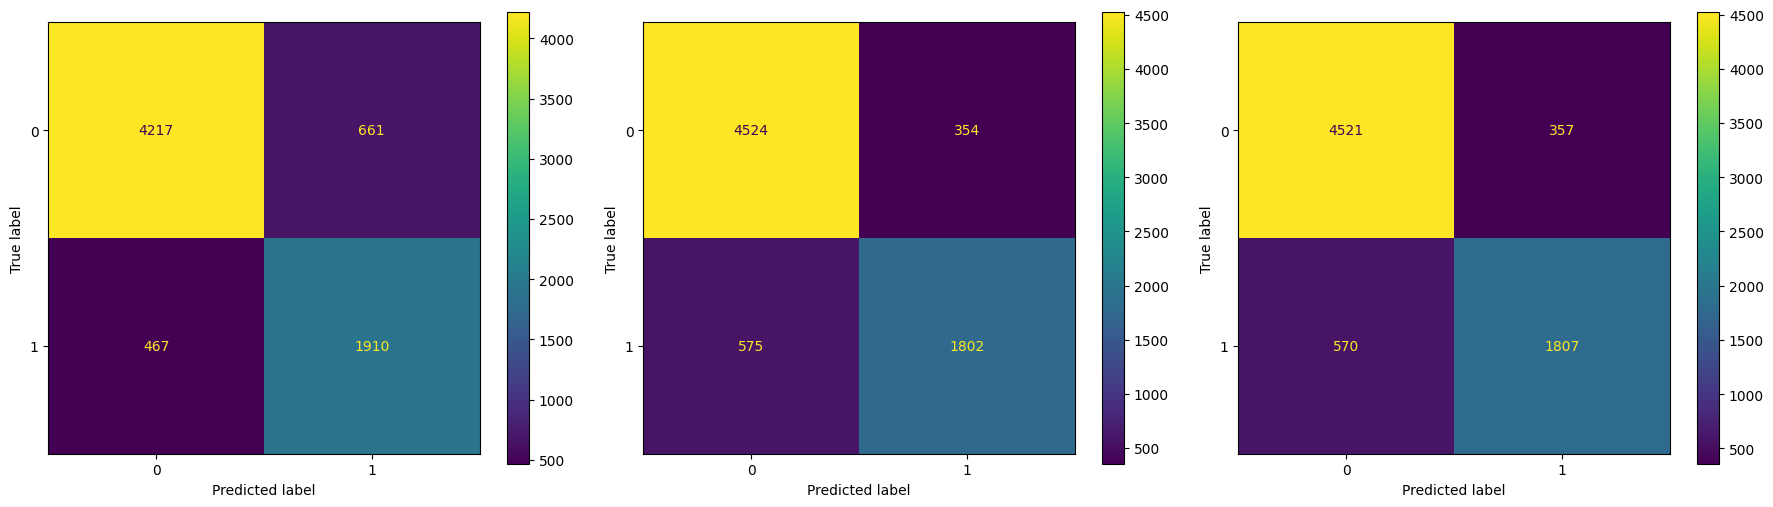

In [260]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_selected, y_test, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test_selected, y_test, ax=axes[1])
ConfusionMatrixDisplay.from_estimator(best_lgbm, X_test_selected, y_test, ax=axes[2])
plt.tight_layout()
plt.show()

### 7.4 Salvamento dos Modelos com Pickle

In [261]:
with open('models/best_rf.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

with open('models/best_xgb.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

with open('models/best_lgbm.pkl', 'wb') as file:
    pickle.dump(best_lgbm, file)